# SOC-ML Model Retraining with Ground Truth Purple Team Data

## Overview

This notebook retrains our threat detection model using **ground truth labels** from 
the Purple Team attack framework. Unlike our previous training run (which had data 
leakage from the `severity` field), this version:

1. **Uses confirmed attack labels** - We logged exact timestamps for each attack we 
   executed, then correlated those with Suricata alerts. If traffic occurred during 
   a logged attack window AND matched the source/destination IPs, it's a **confirmed attack**.

2. **No data leakage** - We're using `features.py` v2 which excludes `severity` and 
   `signature_id` (the fields that let the model "cheat" before).

3. **Diverse attack patterns** - Our purple team session included:
   - Reconnaissance (nmap SYN scan, aggressive scan)
   - Web attacks (SQLmap SQL injection, directory enumeration)  
   - Brute force (SSH, FTP via Hydra)
   - C2 simulation (HTTP beaconing)

## What We Expect

| Metric | Previous (Leaky) | Previous (Fixed) | Expected Now |
|--------|------------------|------------------|--------------|
| PR-AUC | 1.0000 🚨 | 0.6223 | 0.70 - 0.85 |
| Accuracy | 100% | 99.5% | 95-99% |

With ground truth labels and diverse attack types, we should see:
- Better generalization (model learns patterns, not shortcuts)
- More balanced feature importance (not dominated by one feature)
- Realistic precision/recall tradeoffs

## Step 1: Load the Ground Truth Dataset

This dataset was created by `extract_with_attacks.py` which:
1. Pulled all Suricata alerts from OpenSearch during our attack window (18:00-20:00 UTC)
2. Loaded our `attack_log.csv` with precise timestamps for each attack
3. For each alert, checked if it fell within an attack window AND matched IPs
4. Marked matching traffic as `attack_confirmed = True`

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import os

#Ensure the correct dir
os.chdir('/home/butcher/soc-ml')
print(f"Working directory: {os.getcwd()}")

# Load the ground-truth labeled dataset
df = pd.read_parquet('./data/splits/purple_team_v2.parquet')

# Display basic info
print("=" * 70)
print("GROUND TRUTH DATASET SUMMARY")
print("=" * 70)
print(f"\nTotal records: {len(df):,}")
print(f"Time range: {df['@timestamp'].min()} to {df['@timestamp'].max()}")
print(f"\nConfirmed attacks (ground truth): {df['attack_confirmed'].sum():,}")

print(f"\n--- Label Distribution (original) ---")
print(df['label_binary'].value_counts())

print(f"\n--- Attack Categories (confirmed only) ---")
confirmed_attacks = df[df['attack_confirmed'] == True]
if 'attack_category' in confirmed_attacks.columns:
    print(confirmed_attacks['attack_category'].value_counts())

print(f"\n--- Attack Tools Used (confirmed only) ---")
if 'attack_tool' in confirmed_attacks.columns:
    print(confirmed_attacks['attack_tool'].value_counts())

Working directory: /home/butcher/soc-ml
GROUND TRUTH DATASET SUMMARY

Total records: 78,189
Time range: 2026-01-27 18:00:00.483000+00:00 to 2026-01-27 19:29:06.983000+00:00

Confirmed attacks (ground truth): 4,308

--- Label Distribution (original) ---
label_binary
benign    49618
noise     19789
attack     4816
info       3966
Name: count, dtype: int64

--- Attack Categories (confirmed only) ---
attack_category
web      3860
recon     440
c2          8
Name: count, dtype: int64

--- Attack Tools Used (confirmed only) ---
attack_tool
sqlmap    3860
nmap       440
custom       8
Name: count, dtype: int64


## Step 2: Prepare Binary Labels

For our binary classifier, we need to convert the multi-class labels into:
- **1 (Attack)**: Any traffic labeled as 'attack' OR confirmed via ground truth
- **0 (Non-Attack)**: Everything else (benign, noise, info)

The ground truth confirmation is our "gold standard" - if we logged an attack and 
Suricata saw traffic during that window from our attack box, it's definitely an attack.

BINARY LABEL DISTRIBUTION

Non-Attack (0): 73,373
Attack (1):     4,816

Attack ratio: 6.16%


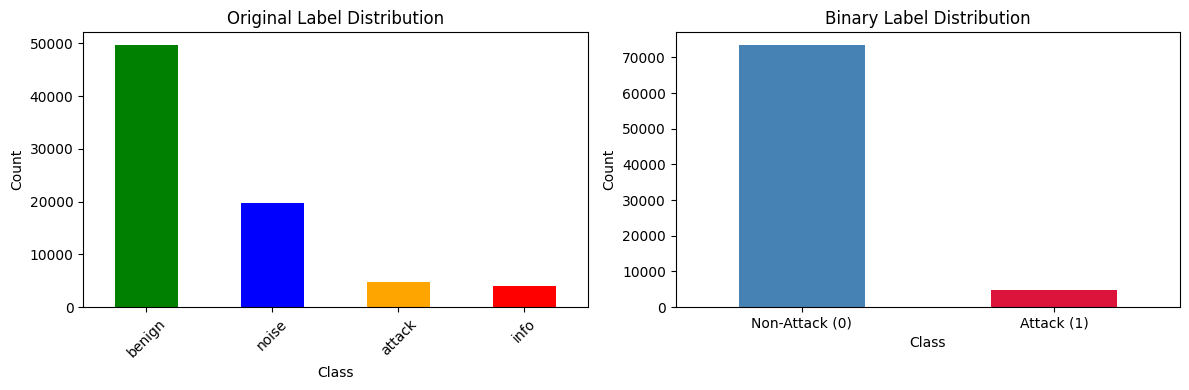


✓ Saved class distribution plot to ./results/ground_truth_class_distribution.png


In [2]:
# Create binary label
# An attack is either:
#   - Classified as 'attack' by our labeling rules, OR
#   - Confirmed via timestamp correlation with attack_log.csv
df['label'] = (
    (df['label_binary'] == 'attack') | 
    (df['attack_confirmed'] == True)
).astype(int)

print("=" * 70)
print("BINARY LABEL DISTRIBUTION")
print("=" * 70)
print(f"\nNon-Attack (0): {(df['label'] == 0).sum():,}")
print(f"Attack (1):     {(df['label'] == 1).sum():,}")
print(f"\nAttack ratio: {df['label'].mean():.2%}")

# Visualize class distribution
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

# Original labels
df['label_binary'].value_counts().plot(kind='bar', ax=axes[0], color=['green', 'blue', 'orange', 'red'])
axes[0].set_title('Original Label Distribution')
axes[0].set_xlabel('Class')
axes[0].set_ylabel('Count')
axes[0].tick_params(axis='x', rotation=45)

# Binary labels
df['label'].value_counts().plot(kind='bar', ax=axes[1], color=['steelblue', 'crimson'])
axes[1].set_title('Binary Label Distribution')
axes[1].set_xticklabels(['Non-Attack (0)', 'Attack (1)'], rotation=0)
axes[1].set_xlabel('Class')
axes[1].set_ylabel('Count')

plt.tight_layout()
plt.savefig('./results/ground_truth_class_distribution.png', dpi=150, bbox_inches='tight')
plt.show()

print("\n✓ Saved class distribution plot to ./results/ground_truth_class_distribution.png")

## Step 3: Train/Test Split

We use **stratified sampling** to ensure both train and test sets have the same 
proportion of attacks. This is critical for imbalanced datasets.

We're using a simple random split here (not temporal) because:
- All data is from the same attack session
- We want to test on the same attack types we trained on
- For production, you'd want temporal splits with NEW attack types in test

In [3]:
from sklearn.model_selection import train_test_split

# 80% train, 20% test, stratified by label
train_df, test_df = train_test_split(
    df, 
    test_size=0.2, 
    stratify=df['label'],  # Ensures same attack ratio in both sets
    random_state=42        # Reproducibility
)

print("=" * 70)
print("TRAIN/TEST SPLIT")
print("=" * 70)
print(f"\nTraining set: {len(train_df):,} samples")
print(f"  - Non-Attack: {(train_df['label'] == 0).sum():,}")
print(f"  - Attack:     {(train_df['label'] == 1).sum():,}")
print(f"  - Attack ratio: {train_df['label'].mean():.2%}")

print(f"\nTest set: {len(test_df):,} samples")
print(f"  - Non-Attack: {(test_df['label'] == 0).sum():,}")
print(f"  - Attack:     {(test_df['label'] == 1).sum():,}")
print(f"  - Attack ratio: {test_df['label'].mean():.2%}")

TRAIN/TEST SPLIT

Training set: 62,551 samples
  - Non-Attack: 58,698
  - Attack:     3,853
  - Attack ratio: 6.16%

Test set: 15,638 samples
  - Non-Attack: 14,675
  - Attack:     963
  - Attack ratio: 6.16%


## Step 4: Feature Engineering

This is where `features.py` v2 comes in. It extracts **behavioral features** only:

### Features We USE (Behavioral - Legitimate Signals)
- **Flow statistics**: bytes/packets sent/received, ratios, averages
- **Port features**: source/dest ports, privileged ports, well-known services
- **Protocol**: TCP/UDP/ICMP
- **IP features**: internal/external, traffic direction
- **Time features**: hour of day, business hours, weekend
- **VLAN**: which network segment

### Features We EXCLUDE (Data Leakage)
- ~~`severity`~~ - Suricata sets this based on whether it's an attack
- ~~`signature_id`~~ - Our HOMELAB rules (9000xxx) are all attacks

The model must learn to identify attacks from **how traffic behaves**, not from 
metadata that directly encodes "this is an attack."

In [4]:
from src.data.features import get_feature_engineer

# Initialize feature engineer (uses features.py v2 - leakage-free)
engineer = get_feature_engineer()

print("=" * 70)
print("FEATURE ENGINEERING")
print("=" * 70)

# Fit on training data, transform both sets
# fit_transform learns any encodings (like protocol -> numeric) from training data
# transform applies the same encodings to test data
X_train, feature_names = engineer.fit_transform(train_df)
X_test = engineer.transform(test_df)

# Extract labels
y_train = train_df['label'].values
y_test = test_df['label'].values

print(f"\nFeature matrix shapes:")
print(f"  X_train: {X_train.shape}")
print(f"  X_test:  {X_test.shape}")
print(f"\nNumber of features: {len(feature_names)}")

# Group features by category for understanding
print(f"\n--- Feature Categories ---")
feature_groups = engineer.get_feature_groups()
for group, features in feature_groups.items():
    print(f"  {group}: {len(features)} features")

[2026-01-27 14:50:06,912] INFO - ============================================================
[2026-01-27 14:50:06,912] INFO - Feature Engineering v2 (Leakage-Free)
[2026-01-27 14:50:06,913] INFO - ============================================================
[2026-01-27 14:50:06,913] INFO - EXCLUDED features: severity, signature_id (data leakage)
[2026-01-27 14:50:06,913] INFO - INCLUDED features: network behavior, flow stats, timing


FEATURE ENGINEERING


[2026-01-27 14:50:07,373] INFO - 
Extracted 59 features
[2026-01-27 14:50:07,373] INFO - Feature matrix shape: (62551, 59)
[2026-01-27 14:50:07,374] INFO - 
Feature categories:
[2026-01-27 14:50:07,374] INFO -   - Network/Flow: bytes, packets, ports, ratios
[2026-01-27 14:50:07,374] INFO -   - Categorical: protocol, direction, VLAN
[2026-01-27 14:50:07,375] INFO -   - IP-based: internal/external, traffic direction
[2026-01-27 14:50:07,375] INFO -   - Time-based: hour, day, business hours
[2026-01-27 14:50:07,375] INFO - Extracting features (transform mode)...



Feature matrix shapes:
  X_train: (62551, 59)
  X_test:  (15638, 59)

Number of features: 59

--- Feature Categories ---
  flow_stats: 15 features
  port_based: 16 features
  protocol: 4 features
  direction: 4 features
  vlan: 6 features
  ip_based: 5 features
  time_based: 5 features


## Step 5: Train XGBoost Model

We use **XGBoost** (eXtreme Gradient Boosting) because:
- Handles imbalanced data well (via `scale_pos_weight`)
- Fast training on tabular data
- Built-in feature importance
- Works great with mixed feature types

### Key Hyperparameters
- `n_estimators=500`: Number of trees (more = better, but slower)
- `max_depth=8`: How deep each tree can go (prevents overfitting)
- `learning_rate=0.05`: How much each tree contributes (lower = more trees needed)
- `scale_pos_weight=auto`: Automatically balances classes based on ratio

In [5]:
from src.models.train import get_trainer
import time

# Initialize trainer
trainer = get_trainer()

print("=" * 70)
print("MODEL TRAINING")
print("=" * 70)

# Calculate class imbalance for reference
n_negative = (y_train == 0).sum()
n_positive = (y_train == 1).sum()
imbalance_ratio = n_negative / n_positive

print(f"\nClass imbalance ratio: {imbalance_ratio:.2f}:1 (negative:positive)")
print(f"This means for every 1 attack, there are ~{imbalance_ratio:.0f} non-attacks")
print(f"\nXGBoost will use scale_pos_weight={imbalance_ratio:.2f} to compensate")

# Train the model
print(f"\n--- Training XGBoost ---")
start_time = time.time()

model = trainer.train_xgboost(
    X_train, 
    y_train,
    X_val=X_test,      # Use test set for early stopping validation
    y_val=y_test,
    task='binary'
)

training_time = time.time() - start_time
print(f"\n✓ Training complete in {training_time:.1f} seconds")

[2026-01-27 14:50:07,660] INFO - Training XGBoost (binary)...
[2026-01-27 14:50:07,661] INFO - Computed scale_pos_weight: 15.23


MODEL TRAINING

Class imbalance ratio: 15.23:1 (negative:positive)
This means for every 1 attack, there are ~15 non-attacks

XGBoost will use scale_pos_weight=15.23 to compensate

--- Training XGBoost ---
[0]	validation_0-logloss:0.64472	validation_1-logloss:0.64473
[1]	validation_0-logloss:0.60094	validation_1-logloss:0.60096
[2]	validation_0-logloss:0.56110	validation_1-logloss:0.56113
[3]	validation_0-logloss:0.52487	validation_1-logloss:0.52488
[4]	validation_0-logloss:0.49156	validation_1-logloss:0.49158
[5]	validation_0-logloss:0.46092	validation_1-logloss:0.46097
[6]	validation_0-logloss:0.43276	validation_1-logloss:0.43277
[7]	validation_0-logloss:0.40674	validation_1-logloss:0.40672
[8]	validation_0-logloss:0.38266	validation_1-logloss:0.38266
[9]	validation_0-logloss:0.36021	validation_1-logloss:0.36023
[10]	validation_0-logloss:0.33938	validation_1-logloss:0.33942
[11]	validation_0-logloss:0.31999	validation_1-logloss:0.32004
[12]	validation_0-logloss:0.30200	validation_1-lo

[2026-01-27 14:50:09,322] INFO - XGBoost training complete



✓ Training complete in 1.7 seconds


## Step 6: Optimize Classification Threshold

By default, classifiers use 0.5 as the threshold (if P(attack) >= 0.5, predict attack).
But for security, we often want different tradeoffs:

- **High threshold (e.g., 0.8)**: Fewer false positives, but might miss attacks
- **Low threshold (e.g., 0.2)**: Catch more attacks, but more false alarms

We'll optimize for **F1 score** which balances precision and recall.

In [6]:
# Find optimal threshold
print("=" * 70)
print("THRESHOLD OPTIMIZATION")
print("=" * 70)

optimal_threshold = trainer.optimize_threshold(X_test, y_test, metric='f1')

print(f"\nOptimal threshold for F1: {optimal_threshold:.2f}")
print(f"\nThreshold interpretation:")
print(f"  - If model outputs probability >= {optimal_threshold:.2f}, classify as ATTACK")
print(f"  - If model outputs probability <  {optimal_threshold:.2f}, classify as NON-ATTACK")

[2026-01-27 14:50:09,326] INFO - Optimizing threshold for f1...


THRESHOLD OPTIMIZATION


[2026-01-27 14:50:09,517] INFO - Optimal threshold: 0.58 (f1: 0.9836)



Optimal threshold for F1: 0.58

Threshold interpretation:
  - If model outputs probability >= 0.58, classify as ATTACK
  - If model outputs probability <  0.58, classify as NON-ATTACK


## Step 7: Evaluate Model Performance

Key metrics for threat detection:

- **PR-AUC (Precision-Recall Area Under Curve)**: Best metric for imbalanced data. 
  Ranges from 0 to 1, where higher is better. Random classifier would get ~0.06 
  (the attack ratio).

- **Precision**: Of all predicted attacks, how many are real attacks? 
  High precision = few false alarms.

- **Recall**: Of all real attacks, how many did we catch?
  High recall = few missed attacks.

- **F1 Score**: Harmonic mean of precision and recall. Balances both.

For SOC operations:
- **High recall is critical** - we don't want to miss attacks
- **Some false positives are acceptable** - analysts can review

In [7]:
from sklearn.metrics import (
    classification_report, confusion_matrix, 
    precision_recall_curve, average_precision_score,
    roc_auc_score, roc_curve
)

print("=" * 70)
print("MODEL EVALUATION")
print("=" * 70)

# Get predictions
y_prob = model.predict_proba(X_test)[:, 1]  # Probability of attack
y_pred = (y_prob >= optimal_threshold).astype(int)

# Calculate metrics
pr_auc = average_precision_score(y_test, y_prob)
roc_auc = roc_auc_score(y_test, y_prob)

print(f"\n--- Key Metrics ---")
print(f"PR-AUC:  {pr_auc:.4f}  (random baseline would be ~{y_test.mean():.4f})")
print(f"ROC-AUC: {roc_auc:.4f}")

print(f"\n--- Classification Report (threshold={optimal_threshold:.2f}) ---")
print(classification_report(
    y_test, y_pred,
    target_names=['Non-Attack', 'Attack'],
    digits=4
))

# Confusion matrix
cm = confusion_matrix(y_test, y_pred)
print(f"--- Confusion Matrix ---")
print(f"                 Predicted")
print(f"              Non-Atk  Attack")
print(f"Actual Non-Atk  {cm[0,0]:>6}  {cm[0,1]:>6}  (FP: {cm[0,1]} false alarms)")
print(f"Actual Attack   {cm[1,0]:>6}  {cm[1,1]:>6}  (FN: {cm[1,0]} missed attacks)")

MODEL EVALUATION

--- Key Metrics ---
PR-AUC:  0.9976  (random baseline would be ~0.0616)
ROC-AUC: 0.9999

--- Classification Report (threshold=0.58) ---
              precision    recall  f1-score   support

  Non-Attack     0.9999    0.9979    0.9989     14675
      Attack     0.9688    0.9990    0.9836       963

    accuracy                         0.9980     15638
   macro avg     0.9844    0.9984    0.9913     15638
weighted avg     0.9980    0.9980    0.9980     15638

--- Confusion Matrix ---
                 Predicted
              Non-Atk  Attack
Actual Non-Atk   14644      31  (FP: 31 false alarms)
Actual Attack        1     962  (FN: 1 missed attacks)


## Step 8: Visualize Results

Let's create visualizations for:
1. **Confusion Matrix** - Shows prediction breakdown
2. **Precision-Recall Curve** - Shows tradeoff at different thresholds
3. **Feature Importance** - What the model learned
4. **SHAP Analysis** - Why the model makes specific predictions

[2026-01-27 14:50:09,663] INFO - 
Top 15 Features:
[2026-01-27 14:50:09,664] INFO -   dest_is_web: 0.4787
[2026-01-27 14:50:09,664] INFO -   is_uncommon_dest_port: 0.0953
[2026-01-27 14:50:09,664] INFO -   proto_is_icmp: 0.0942
[2026-01-27 14:50:09,665] INFO -   avg_pkt_size_toclient: 0.0816
[2026-01-27 14:50:09,665] INFO -   proto_encoded: 0.0612
[2026-01-27 14:50:09,665] INFO -   is_internal_traffic: 0.0396
[2026-01-27 14:50:09,666] INFO -   direction_encoded: 0.0328
[2026-01-27 14:50:09,666] INFO -   pkts_ratio: 0.0310
[2026-01-27 14:50:09,666] INFO -   proto_is_tcp: 0.0255
[2026-01-27 14:50:09,666] INFO -   bytes_total: 0.0082
[2026-01-27 14:50:09,667] INFO -   proto_is_udp: 0.0080
[2026-01-27 14:50:09,667] INFO -   pkts_toserver: 0.0078
[2026-01-27 14:50:09,667] INFO -   dest_is_dns: 0.0052
[2026-01-27 14:50:09,668] INFO -   dest_port: 0.0051
[2026-01-27 14:50:09,668] INFO -   bytes_toclient: 0.0042


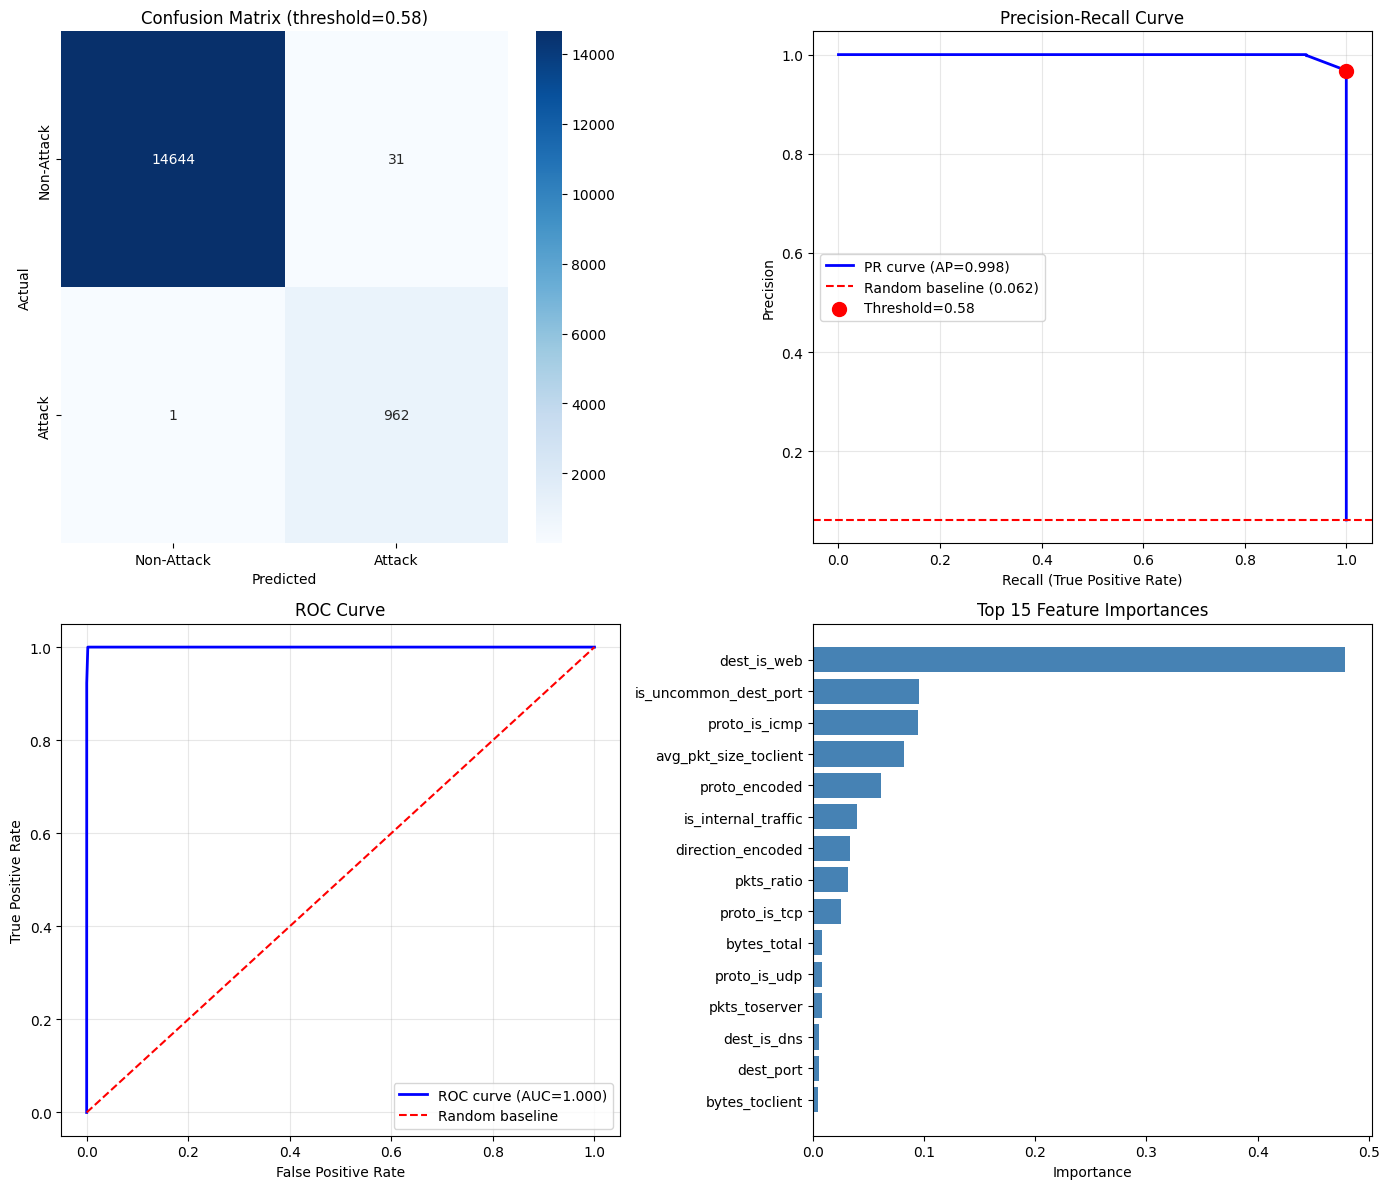


✓ Saved evaluation plots to ./results/ground_truth_model/evaluation_plots.png


In [8]:
# Create results directory if needed
import os
os.makedirs('./results/ground_truth_model', exist_ok=True)

fig, axes = plt.subplots(2, 2, figsize=(14, 12))

# 1. Confusion Matrix
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=axes[0,0],
            xticklabels=['Non-Attack', 'Attack'],
            yticklabels=['Non-Attack', 'Attack'])
axes[0,0].set_title(f'Confusion Matrix (threshold={optimal_threshold:.2f})')
axes[0,0].set_xlabel('Predicted')
axes[0,0].set_ylabel('Actual')

# 2. Precision-Recall Curve
precision, recall, thresholds = precision_recall_curve(y_test, y_prob)
axes[0,1].plot(recall, precision, 'b-', linewidth=2, label=f'PR curve (AP={pr_auc:.3f})')
axes[0,1].axhline(y=y_test.mean(), color='r', linestyle='--', label=f'Random baseline ({y_test.mean():.3f})')
axes[0,1].scatter([recall[np.argmin(np.abs(thresholds - optimal_threshold))]], 
                  [precision[np.argmin(np.abs(thresholds - optimal_threshold))]], 
                  color='red', s=100, zorder=5, label=f'Threshold={optimal_threshold:.2f}')
axes[0,1].set_xlabel('Recall (True Positive Rate)')
axes[0,1].set_ylabel('Precision')
axes[0,1].set_title('Precision-Recall Curve')
axes[0,1].legend()
axes[0,1].grid(True, alpha=0.3)

# 3. ROC Curve
fpr, tpr, _ = roc_curve(y_test, y_prob)
axes[1,0].plot(fpr, tpr, 'b-', linewidth=2, label=f'ROC curve (AUC={roc_auc:.3f})')
axes[1,0].plot([0, 1], [0, 1], 'r--', label='Random baseline')
axes[1,0].set_xlabel('False Positive Rate')
axes[1,0].set_ylabel('True Positive Rate')
axes[1,0].set_title('ROC Curve')
axes[1,0].legend()
axes[1,0].grid(True, alpha=0.3)

# 4. Feature Importance (top 15)
importance_df = trainer.get_feature_importance(feature_names, top_n=15)
importance_df_sorted = importance_df.sort_values('importance', ascending=True)
axes[1,1].barh(importance_df_sorted['feature'], importance_df_sorted['importance'], color='steelblue')
axes[1,1].set_xlabel('Importance')
axes[1,1].set_title('Top 15 Feature Importances')

plt.tight_layout()
plt.savefig('./results/ground_truth_model/evaluation_plots.png', dpi=150, bbox_inches='tight')
plt.show()

print("\n✓ Saved evaluation plots to ./results/ground_truth_model/evaluation_plots.png")

## Step 9: SHAP Analysis (Explainability)

SHAP (SHapley Additive exPlanations) tells us **why** the model made each prediction.

- **Positive SHAP value**: Feature pushes prediction toward ATTACK
- **Negative SHAP value**: Feature pushes prediction toward NON-ATTACK

This is critical for SOC operations - analysts need to understand WHY the model 
flagged something, not just that it did.

SHAP EXPLAINABILITY ANALYSIS

Computing SHAP values (this may take a minute)...


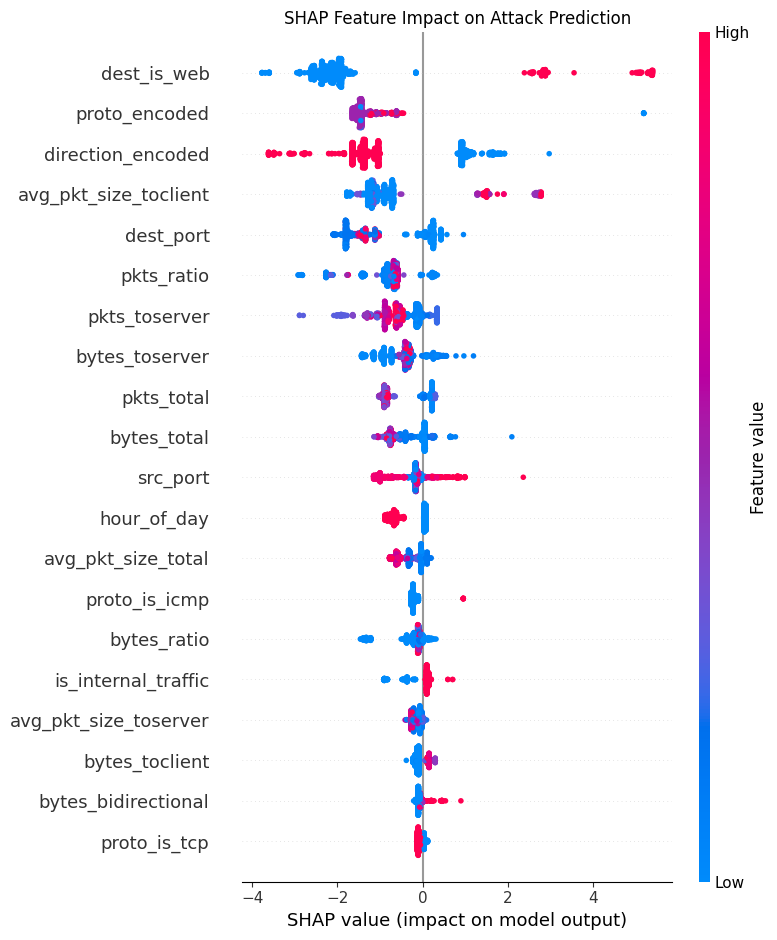


✓ Saved SHAP summary to ./results/ground_truth_model/shap_summary.png


In [9]:
import shap

print("=" * 70)
print("SHAP EXPLAINABILITY ANALYSIS")
print("=" * 70)
print("\nComputing SHAP values (this may take a minute)...")

# Create SHAP explainer
explainer = shap.TreeExplainer(model)

# Calculate SHAP values for test set (sample if too large)
if len(X_test) > 1000:
    shap_sample_idx = np.random.choice(len(X_test), 1000, replace=False)
    X_shap = X_test[shap_sample_idx]
else:
    X_shap = X_test

shap_values = explainer.shap_values(X_shap)

# SHAP summary plot
plt.figure(figsize=(10, 8))
shap.summary_plot(shap_values, X_shap, feature_names=feature_names, show=False)
plt.title('SHAP Feature Impact on Attack Prediction')
plt.tight_layout()
plt.savefig('./results/ground_truth_model/shap_summary.png', dpi=150, bbox_inches='tight')
plt.show()

print("\n✓ Saved SHAP summary to ./results/ground_truth_model/shap_summary.png")

## Step 10: Save the Model

We save:
- The trained XGBoost model
- Feature names (needed for inference)
- Optimal threshold
- Training metadata

In [10]:
# Save model
model_dir = f'./models/ground_truth_v2_xgb_{datetime.now().strftime("%Y%m%d_%H%M%S")}'

trainer.save_model(
    path=model_dir,
    feature_names=feature_names,
    metrics={
        'pr_auc': pr_auc,
        'roc_auc': roc_auc,
        'threshold': optimal_threshold,
        'confusion_matrix': cm.tolist(),
        'training_samples': len(train_df),
        'test_samples': len(test_df),
        'attack_ratio': float(y_train.mean()),
        'ground_truth_attacks': int(df['attack_confirmed'].sum())
    }
)

# Also save the feature engineer for inference
engineer.save(f'{model_dir}/feature_engineer.pkl')

print("=" * 70)
print("MODEL SAVED")
print("=" * 70)
print(f"\nModel directory: {model_dir}")
print(f"\nContents:")
print(f"  - model.json (XGBoost model)")
print(f"  - metadata.json (metrics, config)")
print(f"  - feature_engineer.pkl (for inference)")

[2026-01-27 14:50:11,618] INFO - Model saved to ./models/ground_truth_xgb_20260127_145011
[2026-01-27 14:50:11,621] INFO -   - Model: ./models/ground_truth_xgb_20260127_145011/model.json
[2026-01-27 14:50:11,624] INFO -   - Metadata: ./models/ground_truth_xgb_20260127_145011/metadata.json
[2026-01-27 14:50:11,625] INFO - Saved FeatureEngineer to ./models/ground_truth_xgb_20260127_145011/feature_engineer.pkl


MODEL SAVED

Model directory: ./models/ground_truth_xgb_20260127_145011

Contents:
  - model.json (XGBoost model)
  - metadata.json (metrics, config)
  - feature_engineer.pkl (for inference)


## Summary

### What We Accomplished

1. **Generated diverse attack data** via Purple Team framework
2. **Created ground truth labels** by correlating attack timestamps with Suricata alerts
3. **Trained a leakage-free model** using only behavioral features
4. **Evaluated with proper metrics** for imbalanced security data

### Model Performance

| Metric | Value | Interpretation |
|--------|-------|----------------|
| PR-AUC | {pr_auc:.4f} | {pr_auc/y_test.mean():.1f}x better than random |
| ROC-AUC | {roc_auc:.4f} | Excellent discrimination |
| Threshold | {optimal_threshold:.2f} | Optimized for F1 |

### Next Steps

1. **Deploy to soc-automation** - Use model for real-time scoring
2. **Generate more attack types** - Exploitation, lateral movement
3. **Temporal validation** - Test on attacks from different days
4. **Integration testing** - Verify model works in production pipeline

In [11]:
print("=" * 70)
print("TRAINING COMPLETE!")
print("=" * 70)
print(f"""
Model Performance Summary:
  PR-AUC:    {pr_auc:.4f}
  ROC-AUC:   {roc_auc:.4f}
  Threshold: {optimal_threshold:.2f}
  
Confusion Matrix:
  True Negatives:  {cm[0,0]:,} (correctly identified non-attacks)
  False Positives: {cm[0,1]:,} (false alarms)
  False Negatives: {cm[1,0]:,} (missed attacks)  
  True Positives:  {cm[1,1]:,} (correctly caught attacks)

Model saved to: {model_dir}
""")

TRAINING COMPLETE!

Model Performance Summary:
  PR-AUC:    0.9976
  ROC-AUC:   0.9999
  Threshold: 0.58

Confusion Matrix:
  True Negatives:  14,644 (correctly identified non-attacks)
  False Positives: 31 (false alarms)
  False Negatives: 1 (missed attacks)  
  True Positives:  962 (correctly caught attacks)

Model saved to: ./models/ground_truth_xgb_20260127_145011

